## Task 4

In [1]:
# Importing pytorch module
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import random

from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

PATH = os.getcwd()

torch.manual_seed(2022)
np.random.seed(2022)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ModuleNotFoundError: No module named 'torch'

### Read the data

In [11]:
X_pretrain_csv = pd.read_csv(PATH+'/pretrain_features.csv.zip', compression='zip')
y_pretrain_csv = pd.read_csv(PATH+'/pretrain_labels.csv.zip', compression='zip')
X_train_csv = pd.read_csv(PATH+'/train_features.csv.zip', compression='zip')
y_train_csv = pd.read_csv(PATH+'/train_labels.csv.zip', compression='zip')
X_test_csv = pd.read_csv(PATH+'/test_features.csv.zip', compression='zip')
sample = pd.read_csv(PATH+'/sample.csv')

In [12]:
X_pretrain = np.array(X_pretrain_csv.iloc[:,2:])
y_pretrain = np.array(y_pretrain_csv.iloc[:,1])
X_train = np.array(X_train_csv.iloc[:,2:])
y_train = np.array(y_train_csv.iloc[:,1])
X_test = np.array(X_test_csv.iloc[:,2:])

In [13]:
X_pretrain = torch.from_numpy(X_pretrain).float()
y_pretrain = torch.from_numpy(y_pretrain).float()
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()

### Model

#### Define the model

In [14]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(1000, 1000),
            nn.Hardswish(),
            nn.Linear(1000, 1000),
            nn.Hardswish(),
            nn.Linear(1000, 1000),
            nn.Hardswish(),
            nn.Linear(1000, 1)
        )
  
    def forward(self, x):
        return self.fc(x)

In [15]:
regressor_LUMO = Regressor().to(device)

In [16]:
criterion = nn.MSELoss().to(device)
optim = torch.optim.Adam(regressor_LUMO.parameters(), lr = 1e-5)

In [17]:
# Evaluation function of lumo
def evaluate_LUMO(X_val, y_val, regressor, criterion):
    with torch.no_grad():
        tot_loss = 0

        # If avaiable move data to GPU
        X_val = X_val.float().to(device)

        # Apply the regressor
        predictions = regressor_LUMO(X_val)

        # Calculating the total loss
        loss = criterion(predictions, y_val.unsqueeze(1))

        return loss

#### Train the model with the pretrain data

100%|██████████| 5/5 [01:02<00:00, 12.48s/it]

Total train loss: 0.0274


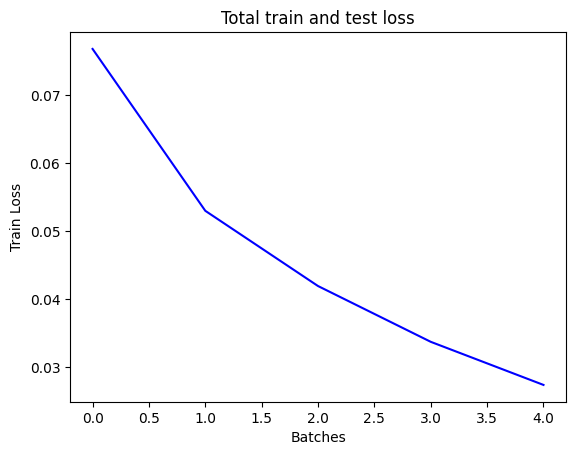

In [18]:
tot_epochs = 5
checkpoint = 5
used_data = 1
batch_size = 64
tot_used_data = int(X_pretrain.shape[0]*used_data)
train_losses = []
test_losses = []

X_pre = X_pretrain.to(device)
y_pre = y_pretrain.to(device)

pretrain_loader = DataLoader(torch.cat((X_pre.to('cpu'), y_pre.unsqueeze(1).to('cpu')), dim=1), batch_size=batch_size, shuffle=True, num_workers=2)

for epoch in tqdm(range(tot_epochs)):
    for batch in pretrain_loader:
        # if avaiable move data to GPU
        batch = batch.to(device)

        X = batch[:, :1000]
        y = batch[:, 1000]

        # zero grad
        optim.zero_grad()

        # Apply Autoencoder
        predictions = regressor_LUMO(X)

        # Calculating the loss
        l2_lambda = 1e-5
        l2_norm = sum(param.pow(2.0).sum() for param in regressor_LUMO.parameters())
        train_loss = criterion(predictions, y.unsqueeze(1)) + l2_lambda * l2_norm

        # backward pass and gradient step
        train_loss.backward()
        optim.step()

    # Save losses
    if used_data < 1:
        test_loss = evaluate_LUMO(X_val, y_val, regressor_LUMO, criterion)
        test_losses.append(test_loss.item())

    train_loss = evaluate_LUMO(X_pre, y_pre, regressor_LUMO, criterion)
    train_losses.append(train_loss.item())

    # Print losses
    if (epoch+1) % checkpoint == 0:
        if used_data < 1:
            print(f'Total train loss: {train_loss:.4f}  |  Total test loss: {test_loss:.4f}')
        else:
            print(f'Total train loss: {train_loss:.4f}')

# Plot the losses
plt.plot(np.asarray(train_losses), 'b')
if used_data < 1:
    plt.plot(np.asarray(test_losses), 'r')
plt.title('Total train and test loss')
plt.xlabel('Batches')
plt.ylabel('Train Loss')
plt.show()

In [19]:

torch.save(regressor_LUMO.state_dict(), PATH+f'/Regressor_LUMO.pt')


#### Train the model with the train data

#### NN training

In [20]:
regressor_HOMO = Regressor().to(device)
regressor_HOMO.load_state_dict(torch.load(PATH+f'/Regressor_LUMO.pt'))

<All keys matched successfully>

In [21]:
criterion = nn.MSELoss().to(device)
optim = torch.optim.Adam(regressor_HOMO.parameters(), lr = 1e-5)

In [22]:
parameters_to_freeze = 4

for index, (name, param) in enumerate(regressor_HOMO.named_parameters()):
    if index < parameters_to_freeze:
        param.requires_grad = False
        print(f'parameter: {name} freezed')
    else:
        param.requires_grad = True
        print(f'parameter: {name} not freezed')

parameter: fc.0.weight freezed
parameter: fc.0.bias freezed
parameter: fc.2.weight freezed
parameter: fc.2.bias freezed
parameter: fc.4.weight not freezed
parameter: fc.4.bias not freezed
parameter: fc.6.weight not freezed
parameter: fc.6.bias not freezed


  5%|▌         | 510/10000 [00:06<01:54, 82.98it/s]

Total train loss: 0.2928


 10%|█         | 1013/10000 [00:12<01:49, 81.86it/s]

Total train loss: 0.2651


 15%|█▌        | 1513/10000 [00:18<01:45, 80.78it/s]

Total train loss: 0.2282


 20%|██        | 2009/10000 [00:24<01:37, 81.88it/s]

Total train loss: 0.1845


 25%|██▌       | 2513/10000 [00:30<01:27, 85.84it/s]

Total train loss: 0.1384


 30%|███       | 3008/10000 [00:36<01:25, 81.58it/s]

Total train loss: 0.0994


 35%|███▌      | 3515/10000 [00:42<01:25, 75.48it/s]

Total train loss: 0.0790


 40%|████      | 4012/10000 [00:49<01:12, 82.46it/s]

Total train loss: 0.0724


 45%|████▌     | 4514/10000 [00:55<01:07, 81.27it/s]

Total train loss: 0.0685


 50%|█████     | 5008/10000 [01:01<01:00, 82.31it/s]

Total train loss: 0.0641


 55%|█████▌    | 5510/10000 [01:07<00:52, 85.61it/s]

Total train loss: 0.0591


 60%|██████    | 6014/10000 [01:13<00:46, 85.83it/s]

Total train loss: 0.0529


 65%|██████▌   | 6509/10000 [01:19<00:42, 81.72it/s]

Total train loss: 0.0459


 70%|███████   | 7013/10000 [01:25<00:35, 82.98it/s]

Total train loss: 0.0383


 75%|███████▌  | 7517/10000 [01:31<00:29, 84.56it/s]

Total train loss: 0.0309


 80%|████████  | 8010/10000 [01:37<00:25, 77.92it/s]

Total train loss: 0.0252


 85%|████████▌ | 8512/10000 [01:43<00:17, 85.56it/s]

Total train loss: 0.0209


 90%|█████████ | 9016/10000 [01:49<00:11, 86.10it/s]

Total train loss: 0.0179


 95%|█████████▌| 9508/10000 [01:55<00:06, 78.95it/s]

Total train loss: 0.0157


100%|██████████| 10000/10000 [02:01<00:00, 82.54it/s]

Total train loss: 0.0141


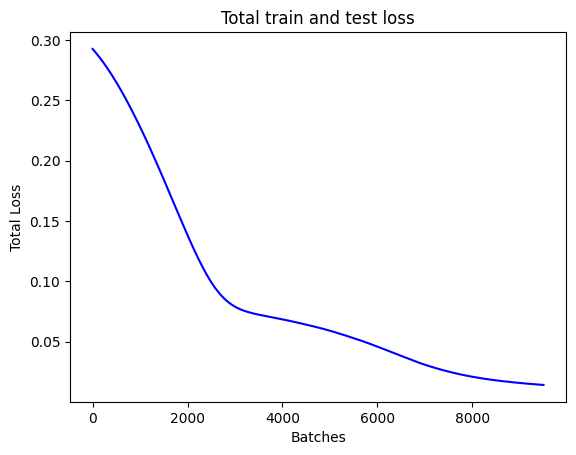

In [23]:
tot_epochs = 10000
checkpoint = 500
tot_used_data = int(X_train.shape[0]*used_data)
train_losses = []

for epoch in tqdm(range(tot_epochs)):
    X_tr = X_train.to(device)
    #X_tr_encoded = autoencoder(X_tr, decoding=False)
    y_tr = y_train.to(device)

    # zero grad
    optim.zero_grad()

    # Apply Autoencoder
    predictions = regressor_LUMO(X_tr) - regressor_HOMO(X_tr)

    # Calculating the loss
    l2_lambda = 1e-5
    l2_norm = sum(param.pow(2.0).sum() for param in regressor_HOMO.parameters())
    train_loss = criterion(predictions, y_tr.unsqueeze(1)) + l2_lambda * l2_norm

    # backward pass and gradient step
    train_loss.backward()
    optim.step()

    # Save losses
    if epoch >= checkpoint:
        train_losses.append(train_loss.item())

    # Print losses
    if (epoch+1) % checkpoint == 0:
        print(f'Total train loss: {train_loss:.4f}')

# Plot the losses
plt.plot(np.asarray(train_losses), 'b')
plt.title('Total train and test loss')
plt.xlabel('Batches')
plt.ylabel('Total Loss')
plt.show()

#### RFR on last layer

### Make the predictions

In [24]:
# Predictions
with torch.no_grad():
    solution = sample

    X_L = regressor_LUMO(X_test.to(device)).squeeze(1)
    X_H = regressor_HOMO(X_test.to(device)).squeeze(1)

    predictions = X_L - X_H

    solution.iloc[:,1] = predictions[:].to('cpu')

    solution.to_csv(PATH+'/Solution.csv')

/var/folders/ht/bl1vljjs6tjck6spryy3gd4w0000gn/T/ipykernel_44351/765756700.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  solution.iloc[:,1] = predictions[:].to('cpu')
